Tensorflow version:  2.5.0
Number of images found:  600
Shape of image:  (60, 160, 3)
Shape of image:  (60, 160, 3)
Shape of image:  (60, 160, 3)
Shape of image:  (60, 160, 3)


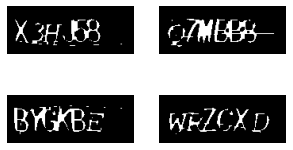

In [1]:
import os
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("Tensorflow version: ", tf.__version__)

seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

img_width, img_height = (160,60)
# Path to the data directory
# data_dir = Path("captcha_binary_image_inv/")
data_dir = Path("binarization_inv_erode/")

# Get list of all the images
images = list(data_dir.glob("*.png"))
print("Number of images found: ", len(images))

# Let's take a look at some samples first. 
# Always look at your data!
sample_images = images[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

In [2]:
# Store all the characters in a set
characters = set()

# A list to store the length of each captcha
captcha_length = []

# Store image-label info
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in images:
    # 1. Get the label associated with each image
    label = img_path.name.split(".png")[0]

    # 2. Store the length of this cpatcha
    captcha_length.append(len(label))
    # 3. Store the image-label pair info
    dataset.append((str(img_path), label))

    # 4. Store the characters present
    for ch in label:
        characters.add(ch)
        
# Sort the characters        
characters = sorted(characters)

# Convert the dataset info into a dataframe
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)

# Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)

print("Number of unqiue charcaters in the whole dataset: ", len(characters))

print("Maximum length of any captcha: ", max(Counter(captcha_length).keys()))
print("Characters present: ", characters,)
print("Total number of samples in the dataset: ", len(dataset))
dataset.head()

Number of unqiue charcaters in the whole dataset:  33
Maximum length of any captcha:  6
Characters present:  ['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Total number of samples in the dataset:  600


,img_path,label
0,binarization_inv_erode/NI56RR.png,NI56RR
1,binarization_inv_erode/E7YKCP.png,E7YKCP
2,binarization_inv_erode/WT7YGX.png,WT7YGX
3,binarization_inv_erode/Z67EEY.png,Z67EEY
4,binarization_inv_erode/C62Q26.png,C62Q26


In [3]:
# Split the dataset into training and validation sets
training_data, validation_data = train_test_split(dataset, test_size=0.1, random_state=seed)

training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

print("Number of training samples: ", len(training_data), training_data.shape)
print("Number of validation samples: ", len(validation_data), validation_data.shape)

char_to_labels = {char:idx for idx, char in enumerate(characters)} # Map text to numeric labels 
labels_to_char = {val:key for key, val in char_to_labels.items()} # Map numeric labels to text


Number of training samples:  540 (540, 2)
Number of validation samples:  60 (60, 2)


In [4]:
# Store arrays in memory as it's not a muvh big dataset
def generate_arrays(df, characters, resize=True, img_height=img_height, img_width=img_width,):
    """Generates image array and labels array from a dataframe.
    
    Args:
        df: dataframe from which we want to read the data
        resize (bool)    : whether to resize images or not
        img_weidth (int): width of the resized images
        img_height (int): height of the resized images
        
    Returns:
        images (ndarray): grayscale images
        labels (ndarray): corresponding encoded labels
    """
    
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items
    
    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # Add only if it is a valid captcha
        
        if is_valid_captcha(label, characters):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)

# Sanity check for corrupted images
def is_valid_captcha(captcha, characters_list):
    #print('===', captcha, characters_list)
    for ch in captcha:
        if not ch in characters_list:
            return False
    return True

# Build training data
training_data, training_labels = generate_arrays(df=training_data, characters=characters)
print("Number of training images: ", training_data.shape)
print("Number of training labels: ", training_labels.shape)

# Build validation data
validation_data, validation_labels = generate_arrays(df=validation_data, characters=characters)
print("Number of validation images: ", validation_data.shape)
print("Number of validation labels: ", validation_labels.shape)

Number of training images:  (540, 60, 160)
Number of training labels:  (540,)
Number of validation images:  (60, 60, 160)
Number of validation labels:  (60,)


In [5]:
class DataGenerator(keras.utils.Sequence):
    """Generates batches from a given dataset.
    
    Args:
        data: training or validation data
        labels: corresponding labels
        char_map: dictionary mapping char to labels
        batch_size: size of a single batch
        img_width: width of the resized
        img_height: height of the resized
        downsample_factor: by what factor did the CNN downsample the images
        max_length: maximum length of any captcha
        shuffle: whether to shuffle data or not after each epoch
    Returns:
        batch_inputs: a dictionary containing batch inputs 
        batch_labels: a batch of corresponding labels 
    """
    
    def __init__(self,
                 data,
                 labels,
                 characters,
                 char_map,
                 batch_size=16,
                 img_width=200,
                 img_height=50,
                 downsample_factor=4,
                 max_length=5,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.characters = characters # 사용된 문자들 총집합
        self.char_map = char_map # 문자들의 Numbe set()
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        # print('=', data.shape, characters, char_map)
        #print(batch_size, img_width, img_height, downsample_factor, max_length, self.indices)
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        # 1. Get the next batch indices
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        #print('==', curr_batch_idx)
        # 2. This isn't necessary but it can help us save some memory
        # as not all batches the last batch may not have elements
        # equal to the batch_size 
        batch_len = len(curr_batch_idx)
        
        # 3. Instantiate batch arrays
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        #print('==', batch_images.shape, batch_labels.shape, input_length.shape, label_length.shape)
        for j, idx in enumerate(curr_batch_idx):
            # 1. Get the image and transpose it
            img = self.data[idx].T
            # 2. Add extra dimenison
            img = np.expand_dims(img, axis=-1)
            # 3. Get the correpsonding label
            text = self.labels[idx]
            # 4. Include the pair only if the captcha is valid
            # print('==', img.shape, text)
            if is_valid_captcha(text, self.characters):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)

        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [6]:
# Batch size for training and validation
batch_size = 8

# Factor  by which the image is going to be downsampled
# by the convolutional blocks
downsample_factor=4

# Maximum length of any captcha in the data
max_length = 6

# Get a generator object for the training data
train_data_generator = DataGenerator(data=training_data,
                                     labels=training_labels,
                                     char_map=char_to_labels,
                                     characters=characters,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

# Get a generator object for the validation data 
valid_data_generator = DataGenerator(data=validation_data,
                                     labels=validation_labels,
                                     characters=characters,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

print(len(train_data_generator), len(valid_data_generator))

68 8


In [7]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # On test time, just return the computed loss
        return loss

def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
    # First conv block
    x = layers.Conv2D(32,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)
    
    # Second conv block
    x = layers.Conv2D(64,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)
    
    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing it to RNNs
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)
    
    # RNNs
    x = layers.Bidirectional(layers.LSTM(128,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64,
                                         return_sequences=True,
                                         dropout=0.25))(x)
    
    # Predictions
    x = layers.Dense(len(characters)+1,
              activation='softmax', 
              name='dense2',
              kernel_initializer='he_normal')(x)
    
    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # Define the model
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')
    
    # Optimizer
    sgd = keras.optimizers.SGD(learning_rate=0.0001,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
    
    # Compile the model and return 
    model.compile(optimizer=sgd)
    return model

model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 160, 60, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 160, 60, 32)  320         input_data[0][0]                 
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 80, 30, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 80, 30, 64)   18496       pool1[0][0]                      
_______________________________________________________________________________________

In [8]:
# Add early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=150,
                                   restore_best_weights=True)

# Train the model
history = model.fit(train_data_generator,
                    validation_data=valid_data_generator,
                    epochs=1000,
                    callbacks=[es])

val_loss: 0.3199
Epoch 807/1000
68/68 [==============================] - 3s 46ms/step - loss: 0.0505 - val_loss: 0.3175
Epoch 808/1000
68/68 [==============================] - 3s 45ms/step - loss: 0.0404 - val_loss: 0.4010
Epoch 809/1000
68/68 [==============================] - 3s 47ms/step - loss: 0.0520 - val_loss: 0.3362
Epoch 810/1000
68/68 [==============================] - 3s 47ms/step - loss: 0.0401 - val_loss: 0.2768
Epoch 811/1000
68/68 [==============================] - 3s 41ms/step - loss: 0.0402 - val_loss: 0.2698
Epoch 812/1000
68/68 [==============================] - 3s 41ms/step - loss: 0.0486 - val_loss: 0.2953
Epoch 813/1000
68/68 [==============================] - 3s 41ms/step - loss: 0.0440 - val_loss: 0.2802
Epoch 814/1000
68/68 [==============================] - 3s 43ms/step - loss: 0.0519 - val_loss: 0.3644
Epoch 815/1000
68/68 [==============================] - 3s 46ms/step - loss: 0.0326 - val_loss: 0.2513
Epoch 816/1000
68/68 [==============================] - 

In [9]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='dense2').output)
prediction_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      [(None, 160, 60, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 160, 60, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 80, 30, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 80, 30, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 40, 15, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 40, 960)           0         
_________________________________________________________________
dense1 (Dense)               (None, 40, 64)            61504 

In [10]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    
    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)
    
    # return final text results
    return output_text

In [11]:
answer = 0
characters_answer = 0
#  Let's check results on some validation samples
for p, (inp_value, _) in enumerate(train_data_generator):
    bs = inp_value['input_data'].shape[0] # batch_size, 
    X_data = inp_value['input_data']
    #print(X_data.shape) # (batch_size, 160, 60, 1)

    labels = inp_value['input_label']
    #print(labels)
    
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    
        ## get score
        # 모든 글자가 같다면,
        if orig_texts[i] == pred_texts[i]:
            answer+=1
            characters_answer+=6
        # 모든 글자가 다 같지 않다면
        else:
            for gc, pc in zip(orig_texts[i], pred_texts[i]):
                if gc==pc: # 한글자씩 비교해서 같으면
                    characters_answer+=1
    
print('최종 answer accuracy:', np.round((answer/len(training_data))*100, 2))

print('최종 characters_answer accuracy:', np.round((characters_answer/(len(training_data)*max_length))*100, 2))

ed: PZ2VNV
Ground truth: 529CLZ 	 Predicted: 529CLZ
Ground truth: 342UX8 	 Predicted: 342UX8
Ground truth: NDKXCZ 	 Predicted: NDKXCZ
Ground truth: 7JZV8K 	 Predicted: 7JZV8K
Ground truth: XQEAJW 	 Predicted: XQEAJW
Ground truth: Y2UYWP 	 Predicted: Y2UYWP
Ground truth: 8VGTHU 	 Predicted: 8VGTHU
Ground truth: A3VPN3 	 Predicted: A3VPN3
Ground truth: WFF7QP 	 Predicted: WFF7QP
Ground truth: 89KP8U 	 Predicted: 89KP8U
Ground truth: K9SJRW 	 Predicted: K9SJRW
Ground truth: S5GYT9 	 Predicted: S5GYT9
Ground truth: JZ4LUW 	 Predicted: JZ4LUW
Ground truth: 6ECT28 	 Predicted: 6ECT28
Ground truth: JSAFRN 	 Predicted: JSAFRN
Ground truth: XBMP2T 	 Predicted: XBMP2T
Ground truth: T6EHLJ 	 Predicted: T6EHLJ
Ground truth: VWA4GB 	 Predicted: VWA4GB
Ground truth: EMDGV2 	 Predicted: EMDGV2
Ground truth: EZR433 	 Predicted: EZR433
Ground truth: R229E4 	 Predicted: R229E4
Ground truth: TGZGSM 	 Predicted: TGZGSM
Ground truth: ZQP87E 	 Predicted: ZQP87E
Ground truth: HSP55C 	 Predicted: HSP55C
Groun

In [12]:
answer = 0
characters_answer = 0

#  Let's check results on some validation samples
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0] # batch_size, 
    X_data = inp_value['input_data']
    print(X_data.shape)

    labels = inp_value['input_label']
    #print(labels)
    
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)
    print(len(orig_texts), len(pred_texts))

    for i in range(bs):
        ## get score
        # 모든 글자가 같다면,
        if orig_texts[i] == pred_texts[i]:
            answer+=1
            characters_answer+=6
            print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]} \t SAME')
        
        # 모든 글자가 다 같지 않다면
        else:
            for gc, pc in zip(orig_texts[i], pred_texts[i]):
                if gc==pc: # 한글자씩 비교해서 같으면
                    characters_answer+=1
                #else:
                #    print(gc, pc)
            print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]} \t NOT SAME')
    
print('최종 answer accuracy:', np.round((answer/len(validation_data))*100, 2))
print('최종 characters_answer accuracy:', np.round((characters_answer/(len(validation_data)*max_length))*100, 2))

(8, 160, 60, 1)
8 8
Ground truth: JUPHA3 	 Predicted: JUPHA3 	 SAME
Ground truth: CLFJW7 	 Predicted: CLFJW7 	 SAME
Ground truth: NLNQTA 	 Predicted: NLNQTA 	 SAME
Ground truth: TQX5L4 	 Predicted: TQX5L4 	 SAME
Ground truth: 5YVQ39 	 Predicted: 5YVQ39 	 SAME
Ground truth: B9SS9T 	 Predicted: B9SS9T 	 SAME
Ground truth: WHQWCJ 	 Predicted: WHQWCJ 	 SAME
Ground truth: KVR2YR 	 Predicted: KVR2YR 	 SAME
(8, 160, 60, 1)
8 8
Ground truth: LXM8DU 	 Predicted: LXM8DU 	 SAME
Ground truth: VW6TMY 	 Predicted: VW6TMYT 	 NOT SAME
Ground truth: SWEGGU 	 Predicted: SWEGGU 	 SAME
Ground truth: QESZ2E 	 Predicted: QESZ2E 	 SAME
Ground truth: 9VR8S2 	 Predicted: 9VR8S2 	 SAME
Ground truth: WLHUTU 	 Predicted: WLHUTJ 	 NOT SAME
Ground truth: GEXRGG 	 Predicted: GEXRGG 	 SAME
Ground truth: 3ZTLEX 	 Predicted: 3ZTLEX 	 SAME
(8, 160, 60, 1)
8 8
Ground truth: 7LEL6B 	 Predicted: 7LEL6B 	 SAME
Ground truth: D6VBQN 	 Predicted: D6VBQN 	 SAME
Ground truth: LZXJD8 	 Predicted: LZXJD8 	 SAME
Ground truth: WDP9Y

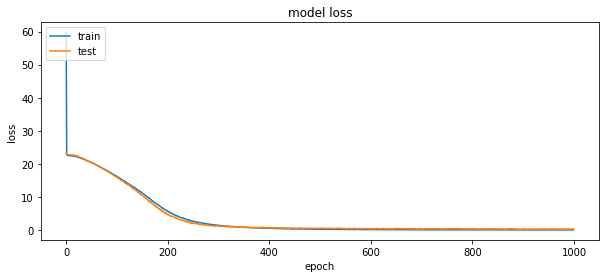

In [13]:
# summarize history for loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# _,ax = plt.subplots(2,2, )
# for i in range(4):
#     img = cv2.imread(str(sample_images[i]))
#     print("Shape of image: ", img.shape)
#     ax[i//2, i%2].imshow(img)
#     ax[i//2, i%2].axis('off')